# Time series prediction using  recurrent neural network (sine wave + noise)
#### Run the cells and try to answer following questions.

## Question 1: 
#### Perform several experiments relating amount of noise in signal and prediction accuracy of simple dense network and RNN. At what noise (std = 0, 0.1, 0.5, 1, 2, 5, ...)  level RNN performs better than dense network in terms of accuracy and in terms of speed of learning? At what noise level both nets perform very poorly?  Choose several representative values of std. 

## Question 2: 
#### Suppose the signal with std=0.5 is coming from real life measurements. You want get rid of noise and to predict next signal value after each 10 steps. what strategy you could apply on signal or on the network to improve predictions? 

## Question 3:
#### Which layer in both - dense and RNN network - you could use if you wanted network to perform averaging of the signal in small sliding by step 1 windows of three points? Which layer woul perform such computation and where would you put this layer?   ( Reference: https://keras.io/api/layers/)

#### Note: you can ignore cells with plotting and inspection outputs 

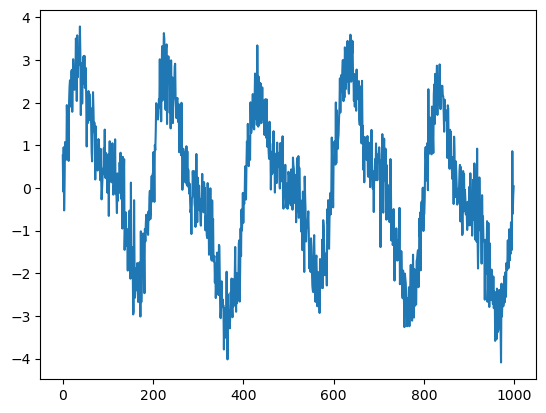

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

start_time = 0

# change end_time to generate longer sequence
#end_time = 1
end_time=10
sample_rate = 1000
time = np.arange(start_time, end_time, 1/sample_rate)
theta = 0
frequency = 10
amplitude = 1
sinewave1 = amplitude * np.sin(2 * np.pi * frequency * time + theta)
sinewave2 = 2*amplitude * np.sin(2 * np.pi * (frequency/2) * time + theta)
sinewave3 = 0.5*amplitude * np.sin(2 * np.pi * (frequency/5) * time + theta)
# mean and std control noise added to the signal, the larger standard deviation, the more noise and more difficult to predict  
nnoise = np.random.normal(0,0.5, len(sinewave3) )

# signal that we are going to predict
signal= sinewave1+sinewave2+sinewave3+nnoise
actual=signal[10:]
plt.plot(signal[:1000])

In [2]:
# keras dataset proportions from signal for prediction
num_train_samples = int(0.5 * len(signal))
num_val_samples = int(0.25 * len(signal))
num_test_samples = len(signal) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)


num_train_samples: 5000
num_val_samples: 2500
num_test_samples: 2500


In [ ]:
# Each 10 steps predict 11 
sequence_length=10

signal_dataset_train = keras.utils.timeseries_dataset_from_array( 
    data = signal[:-11], targets=signal[10:], 
    sequence_length=sequence_length, batch_size=50,
    start_index=0,
    end_index=num_train_samples)

signal_dataset_valid = keras.utils.timeseries_dataset_from_array( 
    data = signal[:-11], targets=signal[10:], 
    sequence_length=sequence_length, batch_size=50,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

signal_dataset_test = keras.utils.timeseries_dataset_from_array( 
    data = signal[:-11], targets=signal[10:], 
    sequence_length=sequence_length, batch_size=50,
    start_index=num_train_samples + num_val_samples)


In [4]:
# inspect the dataset
# Each value at 11th step is target to predict
print("segment of source signal 0:23")
print(signal[0:23])

print("segment of targets 0:3")
print(actual[0:3])

for inputs, targets in signal_dataset_train:
    print("input shape:", inputs.shape)
    print("targets shape:", targets.shape)
    print("\n input signal")
    print(inputs[0:3])
    print("\n target")
    print(targets[0:3])
    break

segment of source signal 0:23
[0.77868567 0.44268417 0.96043875 0.8095446  0.35974111 0.99345541
 0.25786497 1.04865535 0.99485464 0.42120311 1.64921401 1.58473461
 1.66200015 1.10172926 1.47192625 2.82824476 1.76796819 1.66576996
 2.91889686 2.02563448 2.32138807 2.14101958 2.49008485]
segment of targets 0:3
[1.64921401 1.58473461 1.66200015]
input shape: (50, 10)
targets shape: (50,)

 input signal
tf.Tensor(
[[0.77868567 0.44268417 0.96043875 0.8095446  0.35974111 0.99345541
  0.25786497 1.04865535 0.99485464 0.42120311]
 [0.44268417 0.96043875 0.8095446  0.35974111 0.99345541 0.25786497
  1.04865535 0.99485464 0.42120311 1.64921401]
 [0.96043875 0.8095446  0.35974111 0.99345541 0.25786497 1.04865535
  0.99485464 0.42120311 1.64921401 1.58473461]], shape=(3, 10), dtype=float64)

 target
tf.Tensor([1.64921401 1.58473461 1.66200015], shape=(3,), dtype=float64)


In [60]:
#### IGNORE THIS PART 
#### adapt mean prediction function for this dataset?
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

#print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
#print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

#### Simple functional network 

In [11]:
# create simple functional network model as in climate example
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(1, sequence_length))
# we dont need a Flatten layer because input is a sequence 
# x = layers.Flatten()(inputs)
# One hidden layer with 16 unit
x = layers.Dense(16, activation="relu")(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 10)]           0         
                                                                 
 dense_4 (Dense)             (None, 1, 16)             176       
                                                                 
 dense_5 (Dense)             (None, 1, 1)              17        
                                                                 
Total params: 193 (772.00 Byte)
Trainable params: 193 (772.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


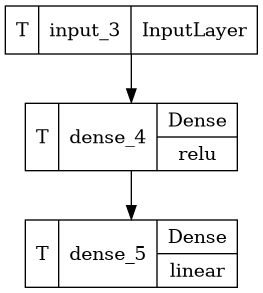

In [12]:
# You must install pydot (`pip install pydot`) and 
# install graphviz (see instructions at https://graphviz.gitlab.io/download/) 
# for plot_model to work.

keras.utils.plot_model(model, expand_nested=True, 
                       show_layer_activations=True, 
                       show_trainable=True)

In [ ]:
# Train simple model  
callbacks = [keras.callbacks.ModelCheckpoint("signal_dense.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(signal_dataset_train, epochs=10, validation_data=signal_dataset_valid, callbacks=callbacks)

model = keras.models.load_model("signal_dense.keras")
print("\n")
print(f"Test MAE: {model.evaluate(signal_dataset_test)[1]:.2f}")
print("\n")

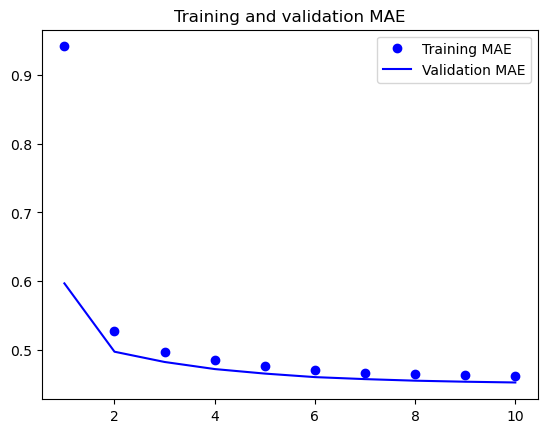

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [20]:
# Plot the actual and predictions
pred = model.predict(signal_dataset_test)
print(pred[:5])
print(pred.shape)

# Here is the actual signal 
actual_test = actual[num_train_samples + num_val_samples :]

# Print the signal 
print("\n actual test")
print(actual_test[:5])

# Verify that actual_test is equal to the target  
for inputs, targets in signal_dataset_test:
    print("\n target")
    print(targets[0:5])
    break

50/50 [==============================] - 0s 7ms/step
[[-0.05547151]
 [ 0.03881076]
 [-0.04160494]
 [ 0.03769944]
 [-0.19644468]]
(2480, 1)

 actual test
[ 0.72383875 -0.20577628 -0.19892673 -0.92849509 -0.08851679]

 target
tf.Tensor([ 0.72383875 -0.20577628 -0.19892673 -0.92849509 -0.08851679], shape=(5,), dtype=float64)


/tmp/ipykernel_65275/2222675435.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(index, actual_test[:200], "b", color="red", label="Actual")


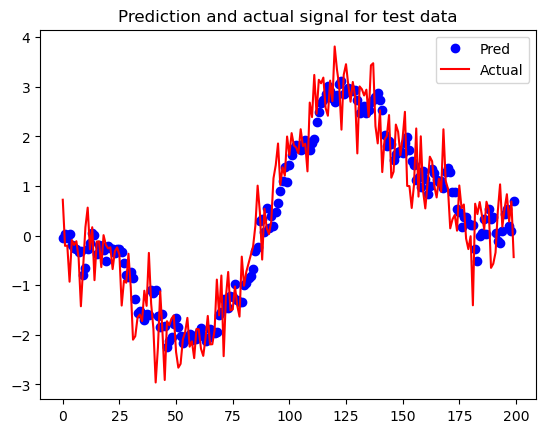

In [21]:
# Plot the actual and predicted 
index = range(200)
plt.figure()
plt.plot(index, pred[:200], "bo", label="Pred")
plt.plot(index, actual_test[:200], "b", color="red", label="Actual")
plt.title("Prediction and actual signal for test data")
plt.legend()
plt.show()

In [ ]:
#### Simple RNN layer

In [41]:
#### Lets try simple RNN
# Time steps 10 , feature 1

inputs = keras.Input(shape=(sequence_length, 1))
# How to achieve better fitting to noise ? 
# Enbedding layer?

x = layers.SimpleRNN(20, recurrent_dropout=0.2 )(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 20)                440       
                                                                 
 dense_11 (Dense)            (None, 1)                 21        
                                                                 
Total params: 461 (1.80 KB)
Trainable params: 461 (1.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


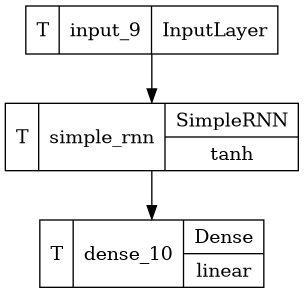

In [34]:
keras.utils.plot_model(model, expand_nested=True, 
                       show_layer_activations=True, 
                       show_trainable=True)

In [42]:
# train the Simple RNN network 
callbacks = [ keras.callbacks.ModelCheckpoint("signal_simple_rnn.keras", save_best_only=True) ]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(signal_dataset_train, epochs=50, verbose=0, validation_data=signal_dataset_valid, callbacks=callbacks)

In [43]:
model = keras.models.load_model("signal_simple_rnn.keras")
print("\n")
print(f"Test MAE: {model.evaluate(signal_dataset_test)[1]:.2f}")
print("\n")



50/50 [==============================] - 0s 3ms/step - loss: 0.3309 - mae: 0.4588
Test MAE: 0.46




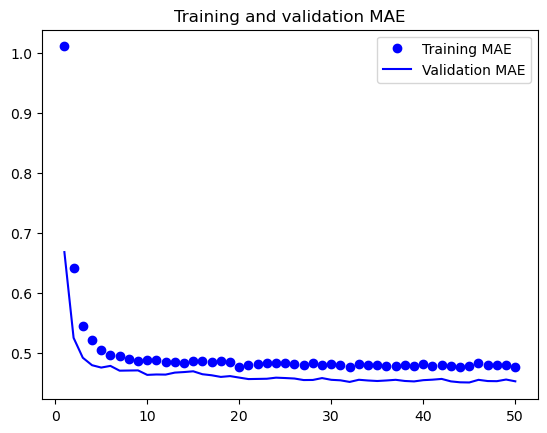

In [44]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

50/50 [==============================] - 0s 8ms/step


/tmp/ipykernel_65275/1699119670.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(index, actual_test[:n], "b", color="red", label="Actual")


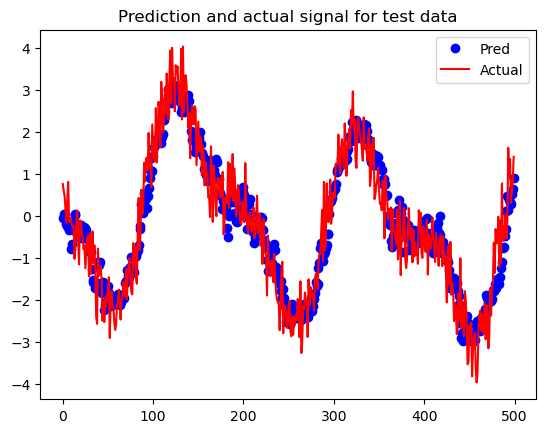

In [47]:
# Plot the actual and predicted 
predicted = model.predict(signal_dataset_test)
# Here is the actual signal 
actual_test = actual[num_train_samples + num_val_samples :]

n=500
index = range(n)
plt.figure()
plt.plot(index, pred[:n], "bo", label="Pred")
plt.plot(index, actual_test[:n], "b", color="red", label="Actual")
plt.title("Prediction and actual signal for test data")
plt.legend()
plt.show()

#### RNN with LSTM units, same sequence of steps. Ignore for now. 
#### Can't find a way to run it. 

Apparently for LSTM layer the data must be organized as 3D tensor [batch, timesteps, features]
As in climate data we had [256, 120 , 14] . How to reorganise our single series data set with dataset

In [30]:
# The LSTM units and Drop out in the network , it returns the last step output

inputs = keras.Input(shape=(sequence_length, sequence_length))
x = layers.LSTM(32, recurrent_dropout=0.2 )(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 10, 10)]          0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                5504      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5537 (21.63 KB)
Trainable params: 5537 (21.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


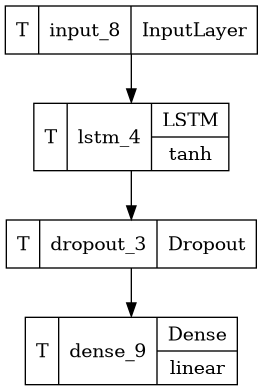

In [31]:
keras.utils.plot_model(model, expand_nested=True, 
                       show_layer_activations=True, 
                       show_trainable=True)

In [36]:
# train the LSTM network 
#callbacks = [ keras.callbacks.ModelCheckpoint("signal_lstm_dropout.keras", save_best_only=True) ]
#model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
#history = model.fit(signal_dataset_train, epochs=50, validation_data=signal_dataset_valid, callbacks=callbacks)